In [ ]:
#References
#https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
#https://pasaentuciudad.com.mx/data-to-model-to-api-an-end-to-end-approach/
#https://github.com/The-AI-Summer/Deep-Learning-In-Production/tree/master/2.%20Writing%20Deep%20Learning%20code:%20Best%20Practises

# Install and import the necessary dependencies

In [ ]:

from google.colab import drive

#This will prompt for authorization.
drive.mount('/content/drive')

#Create a symbolic link, in order no to be able to save weights on drive. Otherwise it gives an error. 
!ln -s /content/drive/My\ Drive /content/mydrive


#Install requirements
%cd mydrive/SentimentAnalysis
!pip install -r requirements.txt 

import os
import sys

import pandas as pd

# import seaborn as sns #visualization.py
# import nltk #visualization.py
# from nltk.corpus import stopwords #visualization.py

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/utils')
import Config, visualization

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/data')
import dataloader, datacleaner

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/models/')
import BaseModel,LSTM

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/configs')
import config_main


# Load data

In [ ]:
input_path = os.path.join(config_main.CFG['data']['base_path'], 
                          config_main.CFG['data']['name'])

#Download and unzip dataset
if not (os.path.isfile(config_main.CFG['data']['url'].split('/')[-1])):
  dataloader.download_dataset_from_url(config_main.CFG['data']['url'])
dataloader.unzip_data_to_folder(input_path, config_main.CFG['data']['url'].split('/')[-1])

#Read unzipped data
print("Reading training data...")
train_data_df = pd.read_csv(os.path.join(input_path, 'training.1600000.processed.noemoticon.csv'),  
                            encoding='latin-1', usecols=[0,5], names=['sentiment','tweet'])

print("Reading testing data...")
test_data_df = pd.read_csv(os.path.join(input_path, 'testdata.manual.2009.06.14.csv'),  
                           encoding='latin-1', usecols=[0,5], names=['sentiment','tweet'])

#Print dataset info
print(train_data_df.info())


# Preprocess data

In [ ]:
# Preprocessing tweets data
print("Cleaning and parsing the tweets from training data...")
train_data_df = train_data_df.iloc[0:5000] #TO-DO: Remove
train_data_df.tweet = train_data_df.tweet.apply(datacleaner.preprocess_tweet)
print("Finished!\n")

# Preprocessing labels to have classes 0 and 1
train_data_df.sentiment = train_data_df.sentiment.apply(lambda value: 1 if value==4 
                                                        else value)

print("Sentiment values: ")
print(train_data_df.sentiment.value_counts())

print(train_data_df.head(5))



# Preprocessing tweets data
print("\nCleaning and parsing the tweets from testing data...")
test_data_df = test_data_df.iloc[0:2000] #TO-DO: Remove
test_data_df.tweet = test_data_df.tweet.apply(datacleaner.preprocess_tweet)
print("Finished!\n")

test_data_df = test_data_df[test_data_df.sentiment!=2] #Remove intermediate polarities
test_data_df.sentiment.value_counts()/test_data_df.shape[0]

test_data_df.sentiment = test_data_df.sentiment.apply(lambda value: 1 if value==4 else value)

print(test_data_df.sentiment.value_counts()/test_data_df.shape[0])


# Preprocessing labels to have classes 0 and 1
test_data_df.sentiment = test_data_df.sentiment.apply(lambda value: 1 if value==4 else value)


# Analyze data
Estimating the vocabulary size and the vector sequence length to be fed to the model every instance is a crucial step for a good model.

This is achieved by analyzing the training dataset, by plotting the 
distribution of tweet lengths across the training data.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Total Unique Words: 1536
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Total words 4897
Total stop words 1836
Ratio of total words to total stop words: 2.667211328976035


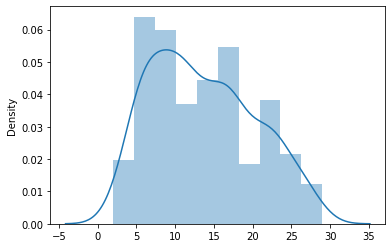

In [5]:
visualization.visualize_tweet_length(test_data_df)

# Train, save/serialize and evaluate the model


In [ ]:
model = LSTM.LSTM(config_main.CFG)
model.create_train_pipeline(train_data_df)
model.data_vectorization(config_main.CFG['model']['data_vectorization']['max_features'], 
                         config_main.CFG['model']['data_vectorization']['max_len'])

model.build_model()
model.train()

model.create_test_pipeline(test_data_df)
model.test()